In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np

from util import *

In [2]:

class Node:
    def __init__(self, parent, state, n_children, terminal_rwd, depth, use_inv=True):
        self.state = np.array(state, dtype=np.int16)
        self.parent = parent
        self.visits = 0
        self.children = [None] * n_children
        self.depth = depth
        self.is_terminal = self.terminal()
        if use_inv:
            self.value = self.inv_axis_dist_value(terminal_rwd)
        else:
            self.value = self.axis_dist_value(terminal_rwd)
        self.subtree_value = 0

    def __str__(self):
        return ("State: " + str(self.state) + "; Value: " + str(self.value)
                + "; Subtree Value: " + str(self.subtree_value) + "; Visits:", str(self.visits))

    def terminal(self, k_eps=1e-4):
        for i in self.state:
            if abs(i) <= k_eps:
                return True
        return False

    def axis_dist_value(self, terminal_rwd):
        if self.is_terminal:
            return terminal_rwd
        x = np.min(np.abs(self.state))
        return - x - self.depth

    def inv_axis_dist_value(self, terminal_rwd):
        if self.is_terminal:
            return terminal_rwd
        return 1 / np.min(np.abs(np.array(self.state))) - self.depth

    def is_leaf(self):
        for i in self.state:
            if i is not None:
                return False
        return True

    @staticmethod
    def completion_value(root): # for the root node
        return np.sqrt(np.linalg.norm(root.state))


In [3]:
class MCTS:
    def __init__(self, actions, C, weight):
        self.actions = actions
        self.k_C = C
        self.k_weight = weight  # diminish future reward estimations (per move in the future)
        self.k_move_penalty = -1    # penalty for one move without finding a terminal state
        self.root = None

    def pick_child(self, node):
        # UCT
        t = []
        for i in node.children:
            if i is None:
                continue
            t.append(UCT_fn(i, self.k_C))
        return int(random.choice(np.squeeze(np.argwhere(t == np.max(t)), axis=1)))

    def default_search(self, node):
        """
        If node is fully explored (neither child is None), return True
        Otherwise, initialize value of a random unexplored next state

        :param node: node to search from
        :return: if fully explored, True. Else, value of the random unexplored next state
        """
        possible = []
        for i in range(len(node.children)):
            if node.children[i] is None:
                possible.append(i)
        if len(possible) == 0:
            return True

        i = random.choice(possible)
        # if unexplored or non-terminal, get value
        state = self.actions[i](node.state)
        node.children[i] = Node(node, state, len(self.actions), Node.completion_value(self.root), depth=node.depth+1)
        return node.children[i]

    def tree_policy(self, node, computations):
        while node.is_terminal is False:
            explored = self.default_search(node)
            if explored is not True:
                return explored, computations + 1
            node = node.children[self.pick_child(node)]
            # node = random.choice(node.children)
        return node, computations + 1

    def sum_prop(self, node):
        """
        Backprop up from a leaf using sum of rewards. Parent subtree value takes sum of child subtree values.

        :param node: of subtree
        """
        node.subtree_value = node.value
        if not node.is_leaf():
            for i in node.children:
                if i is None:
                    continue
                node.subtree_value += self.k_weight * i.subtree_value
        node.visits += 1
        if node.parent is None:
            return
        self.sum_prop(node.parent)

    def run(self, root, comp_limit=10):
        """
        Shoutout "A Survey of MCTS Methods"
        :param node: the current state
        :param comp_limit: max number of possible future scenarios to compute (carries over)
        :return: index corresponding to best action
        """
        self.root = root
        if root.is_terminal:
            return True
        comps = 0
        while comps < comp_limit:
            node, comps = self.tree_policy(self.root, comps)
            self.sum_prop(node)

        rv = self.pick_child(root)
        return rv

In [4]:
def get_data(fname):
    x = np.array(np.loadtxt(fname, delimiter=","), dtype=np.float32)
    return x[:,:-1], x[:,-1]


def plot_db(mcts, actions, comp_limit, ranges):
    X = ranges[0]
    Y = ranges[1]
    action_plot = [[] for i in actions]
    for i in X:
        for j in Y:
            result = mcts.run(Node(None, (i,j), len(actions),0, np.linalg.norm([i,j])), comp_limit=comp_limit)
            action_plot[result].append((i,j))
    for i in range(len(action_plot)):
        action = np.array(action_plot[i])
        plt.scatter(action[:,0], action[:,1], color=("C"+str(i)), label=action)
    plt.show()

In [5]:
def test(x, y, C, weight=1., comp_limit=10, actions=(a_subtract, a_swap), zero_index=False, dbs=None):
    correct = 0
    mcts = MCTS(actions, C, weight)
    guess_dist = [0] * len(actions)
    if zero_index:
        y = y - np.ones(len(y))
    for i in range(len(x)):
        rv = mcts.run(Node(None, x[i], len(actions), 0, np.linalg.norm(x[i])), comp_limit=comp_limit)
        if rv == y[i] or rv is True:
            correct += 1
        guess_dist[rv] += 1
        # if (i+1) % 100 == 0:
            # print("epoch", i+1, ":", correct / (i+1))

    if dbs is not None:
        # graphing decision boundary
        plot_db(mcts, actions, comp_limit, ranges=dbs)
    return correct / len(x), guess_dist


def run_test(data_name, actions, C, cases=100, lookahead=100, weight=1., zero_index=False, dbs=None):
    test_X, test_Y = get_data(data_name)
    test_Y.reshape(-1, 1)

    acc, guesses = test(test_X[:cases], test_Y[:cases],
                        C, weight, comp_limit=lookahead, actions=actions, zero_index=zero_index, dbs=dbs)
    print("Test Accuracy:", acc)
    print("Guess Distribution:", guesses)

In [6]:
k_C = 1 / math.sqrt(2)  # satisfies Hoeffding Ineq (Kocsis and Szepesvari)
k_cases = 2000

k_dbound_size = 100

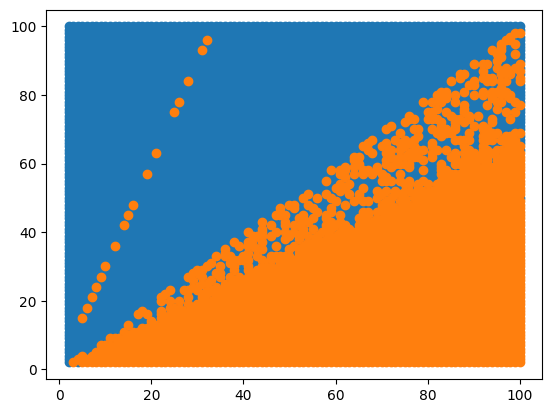

Test Accuracy: 0.8785
Guess Distribution: [1263, 737]


In [7]:
dual_file = "test_data/test_simple.csv"

db2 = np.linspace(2, k_dbound_size, k_dbound_size - 1)
two_dbs =[db2, db2]

run_test(dual_file, [a_subtract, a_swap], k_C, k_cases, lookahead=10, dbs=two_dbs)
# ~90% accuracy

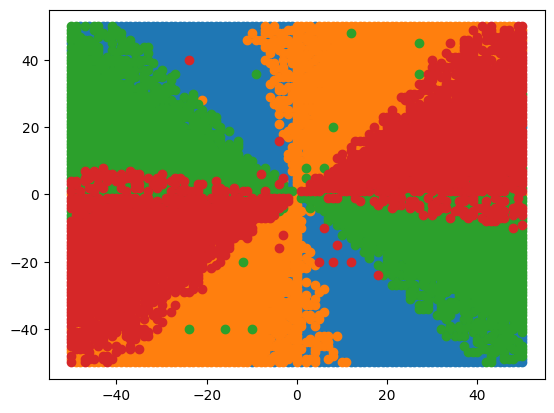

Test Accuracy: 0.07707707707707707
Guess Distribution: [256, 252, 236, 255]


In [8]:
quad_file = "../Donald/four_step_euclidean/four_directions_test.csv"     # thanks, donald

db4 = np.linspace(-k_dbound_size/2, k_dbound_size/2, k_dbound_size+1)
quad_dbs = [db4, db4]
run_test(quad_file, [a_plsy, a_suby, a_plsx, a_subx], k_C, k_cases, lookahead=100, zero_index=True, dbs=quad_dbs)
# 8% accuracy on Donald test csv